![](https://github.com/datoujinggzj/WhaleDataScienceProject/blob/master/pic/15.png?raw=true)

1. [不平衡类别数据的影响](#不平衡类别数据的影响)
2. [不平衡类别数据的处理方法](#不平衡类别数据的处理方法)
   - 2.1 [重采样](#重采样)
   - 2.2 [Imblearn模块](#Imblearn模块)
3. [练习](#练习)

<div class="alert alert-block alert-warning">
<center><b>【第三阶段】项目日志</b></center>
    
    
第三阶段：【类别不平衡学习深度解析】
   
**第三节阶段核心目的：深度解析不平衡类别学习的相关内容。
    
**难度（最高5星）：**⭐⭐⭐
    
**第三阶段周期：** 2022年4月15日 至 2022年4月22日（北京时间）


Good Luck!
</div>

# 不平衡类别数据的影响

本数据大概有97%的训练集数据被归类为0，也就是不索赔，只有3%左右的数据被归类为1，也就是索赔。

那么我们其实所期待的是：

训练集有更多正类，也就是更多的1，更多的发生索赔的数据，这样才能在输入新数据时，更好的预测正类。

给大家举个例子，为什么我们不喜欢类别不平衡的数据。

In [1]:
import numpy as np
import pandas as pd

from collections import Counter

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,12)
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

from sklearn.metrics import roc_curve, roc_auc_score

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


不发起索赔: 573518
发起索赔: 21694
比例: 26.44 : 1


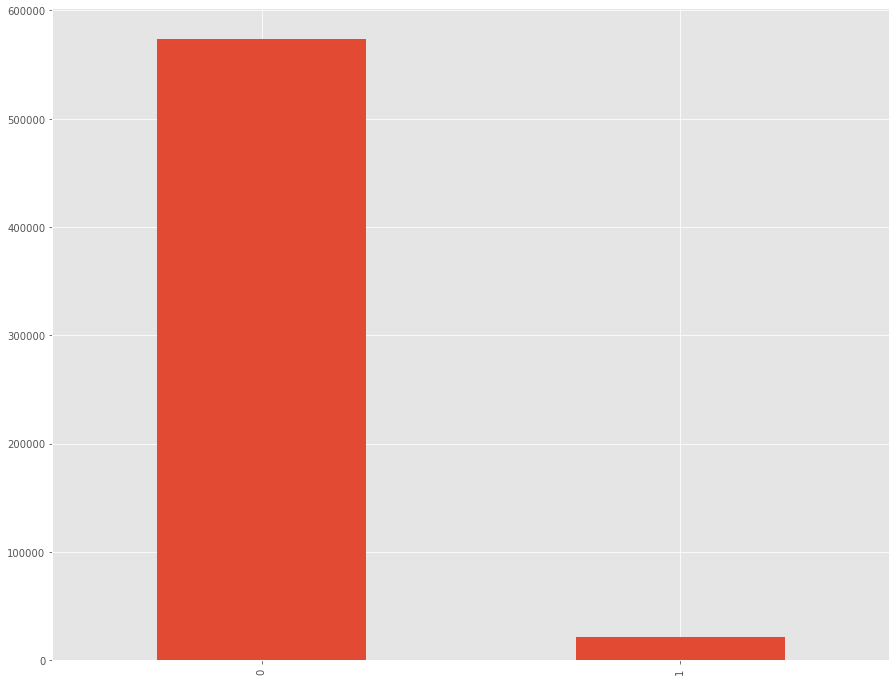

In [2]:
train = pd.read_csv('/Users/sarahluym/Desktop/求职/Projects/Github/WhaleDataScienceProject/data/train.csv')

target_count = train.target.value_counts()
print('不发起索赔:', target_count[0])
print('发起索赔:', target_count[1])
print('比例:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar');

可以看出正负类的比例在是1比26左右，表示我们的正例很少很少，也确实，保险行业理赔的情况就是很少，这是风控项目所常见的问题，我们经常会遇到这种情况，这样的数据对一般的机器学习算法是很不友好的，为啥这样说？


比如，我们对数据不进行任何处理，直接运用sklearn的Logistic regression对数据进行分类，我们看看结果。

In [3]:
# 直接run
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 移除id和target
features = train.columns[2:]

X = train[features]
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1996)

model = LogisticRegression(solver = 'liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.34%


哇！我们正确率已经达到96.34%了。

但是事实真的像这个数字一样perfect么？

那我随便拿出一个特征`ps_calc_02`再去预测一下，看看准确率是多少？

In [4]:
model.fit(X_train[['ps_calc_02']], y_train)
y_pred = model.predict(X_test[['ps_calc_02']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.34%


？还是96.34%，说明这么高的准确度其实是个幻觉，是个假象，在类别极度不平衡的时候，我们就不能单单用`accuracy`来去衡量一个分类模型的好坏了。

还记得第一阶段给大家花很多时间讲的metrics么，我们是不是要换一个模型衡量方法尝试一下？

可以看到1的正确率是0，说明我们根本没有预测出正例来。

In [5]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    114686
           1       0.00      0.00      0.00      4357

    accuracy                           0.96    119043
   macro avg       0.48      0.50      0.49    119043
weighted avg       0.93      0.96      0.95    119043



再来看一下roc-auc，可以看到这个模型是完全无效的！

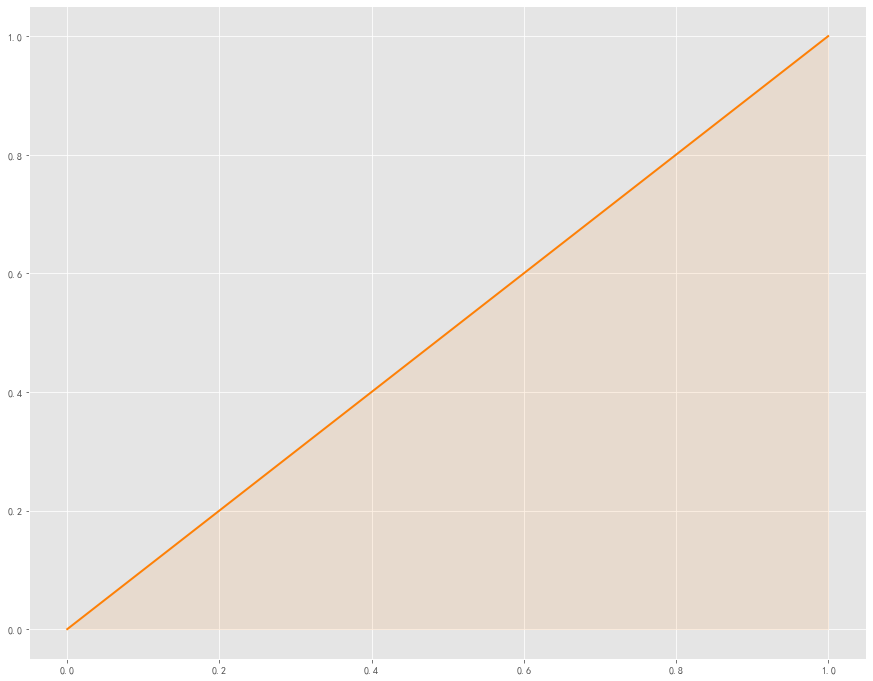

In [6]:
aucroc = roc_auc_score(y_test, y_pred)
fpr, tpr, t = roc_curve(y_test, y_pred)
fig, ax = plt.subplots(nrows=1,ncols=1, sharey=True)

ax.plot([0]+fpr.tolist(), [0]+tpr.tolist(), lw = 2, color = '#fe8006')
ax.fill_between([0]+fpr.tolist(), [0]+tpr.tolist(), color = '#fe8006', alpha=0.1)

所以，我们需要用不平衡学习的知识来处理数据，现在来详细展开！

# 不平衡类别数据的处理方法

![](https://github.com/datoujinggzj/WhaleDataScienceProject/blob/master/pic/16.png?raw=true)

## 重采样

首先，分享一个小白都能理解的最简单的处理方法，就是【重采样】。

其主要包含两种方法：

- 欠采样（undersampling）
- 过采样（oversampling）

<img src="https://pic.imgdb.cn/item/621873142ab3f51d9152bcda.jpg">

### 随机欠采样

欠采样就是：想办法把数据多的那一类（majority class），减少点数据，使得数据量跟数据少的那一类（minority class）匹配。

**方法：从majority class里面随机抽样与minority class等量的数据。**

来看看用Python怎么实现。

In [4]:
# Class count
count_class_0, count_class_1 = train.target.value_counts()

# Divide by class
df_class_0 = train[train['target'] == 0]
df_class_1 = train[train['target'] == 1]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


Random under-sampling:
0    21694
1    21694
Name: target, dtype: int64


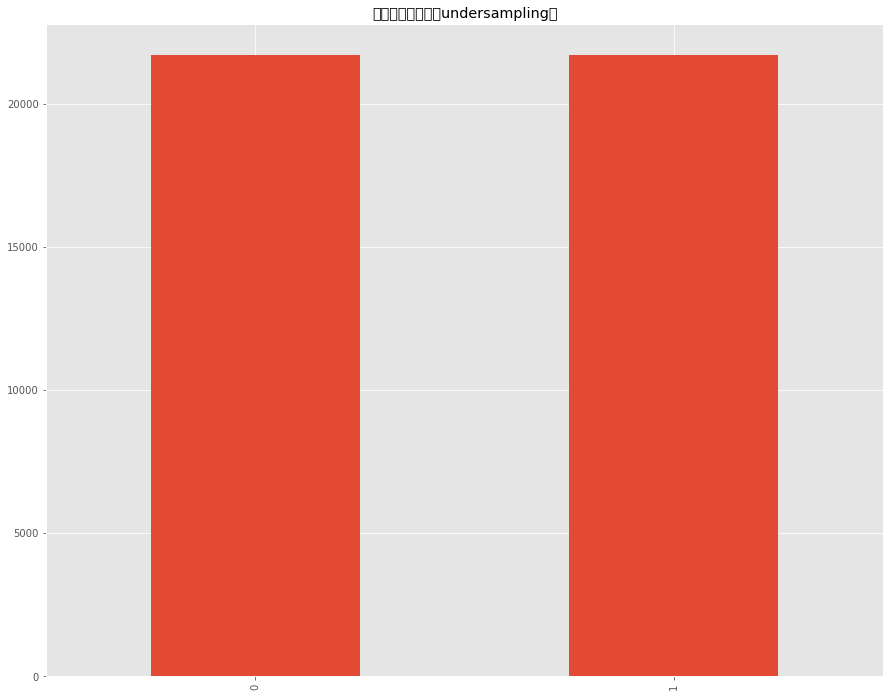

In [5]:
df_class_0_undersampling = df_class_0.sample(count_class_1)
df_undersampling = pd.concat([df_class_0_undersampling, df_class_1], axis=0)

print('Random under-sampling:')
print(df_undersampling.target.value_counts())

df_undersampling.target.value_counts().plot(kind='bar', title='正负类别数据量（undersampling）');

### 随机过采样

过采样就是：想办法把数据少的那一类（minority class），增加点数据，使得数据量跟数据多的那一类（majority class）匹配。

**方法：从minority class里面随机抽样（可重复！）与minority class等量的数据。**

来看看用Python怎么实现。

Random over-sampling:
0    573518
1    573518
Name: target, dtype: int64


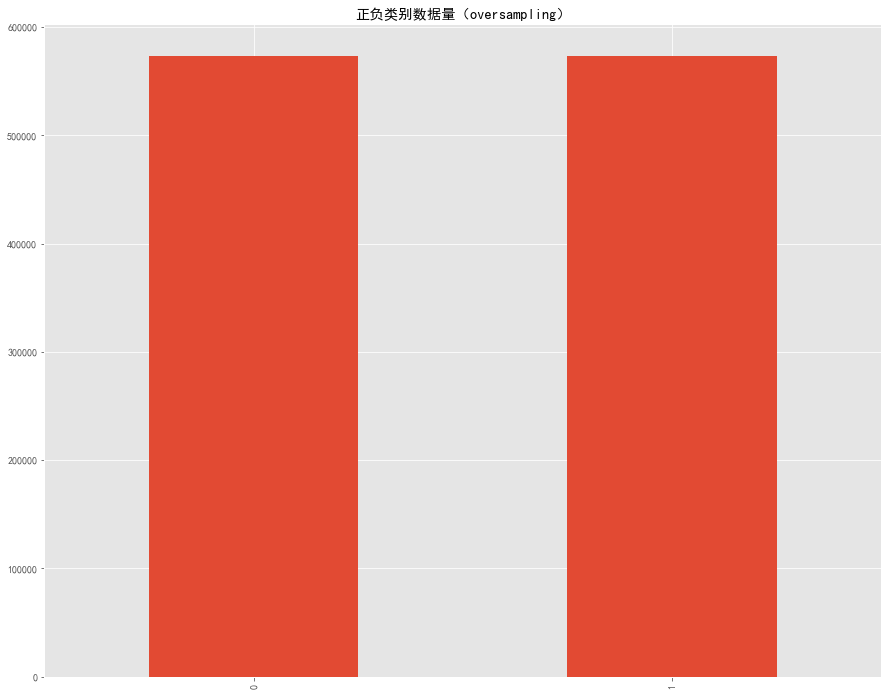

In [9]:
df_class_1_oversampling = df_class_1.sample(count_class_0, replace=True)
df_oversampling = pd.concat([df_class_0, df_class_1_oversampling], axis=0)

print('Random over-sampling:')
print(df_oversampling.target.value_counts())

df_oversampling.target.value_counts().plot(kind='bar', title='正负类别数据量（oversampling）');

但是，对于上述两种方法，虽然简便，但是都有缺点。

欠采样直接从原数据删除了很多样本，这回导致原数据的信息丢失（information loss）。

过采样由于从minority class的样本进行了复制，所以会出现过拟合的问题。

所以，重采样并不是一个最优解。

## Imblearn模块

很多学者也对更复杂的重采样技术进行研究，发表了很多论文等。

例如，我们可以对majority class的数据进行聚类，并通过从每个cluster中删除一些数据来进行欠采样，从而减少信息丢失。

在过采样中，我们不再直接复制那些从minority class取出的样本，而是加一些小小的变化，一些合理的噪声进去，从而增加数据的复杂度和多样性。

👇👇👇点击可跳转！


现在来介绍[Imblearn](https://imbalanced-learn.org/stable/user_guide.html#user-guide)模块。

先来安装一下！

In [6]:
pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
import imblearn

为了可视化，我们取出train里面100个样本。

In [12]:
df_demo = train.copy().sample(100,random_state = 0)

features = df_demo.columns[2:]

X = df_demo[features]
y = df_demo['target']

In [23]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#20beff', '#d80012']
    markers = ['o', '*']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m,
            s = 80
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

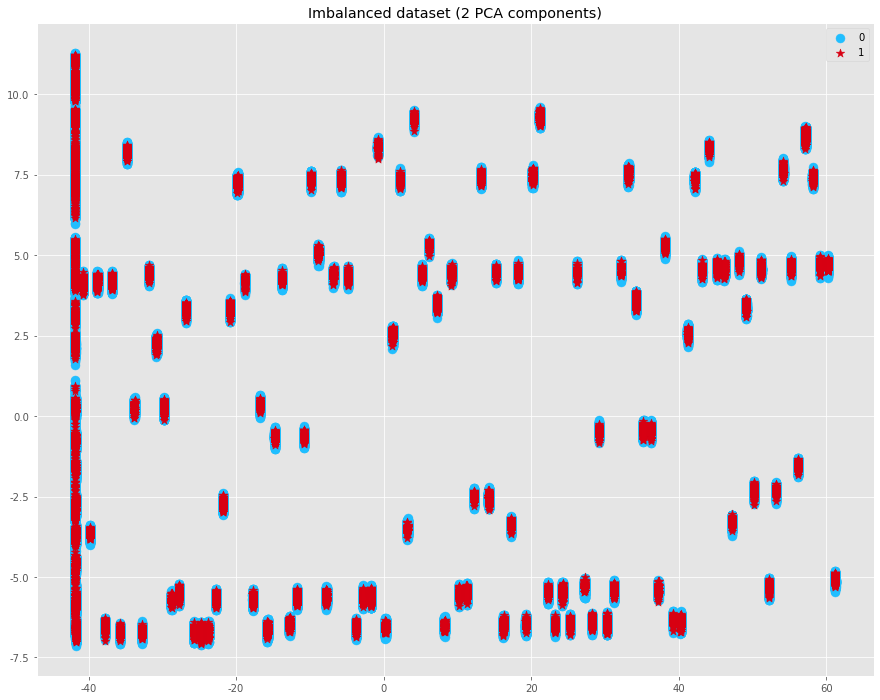

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

### Under-sampling

- RandomUnderSampler
- TomekLinks
- EditedNearestNeighbours
- RepeatedEditedNearestNeighbours
- AllKNN
- ClusterCentroids

#### RandomUnderSampler

[(0, 95), (1, 5)]
[(0, 5), (1, 5)]


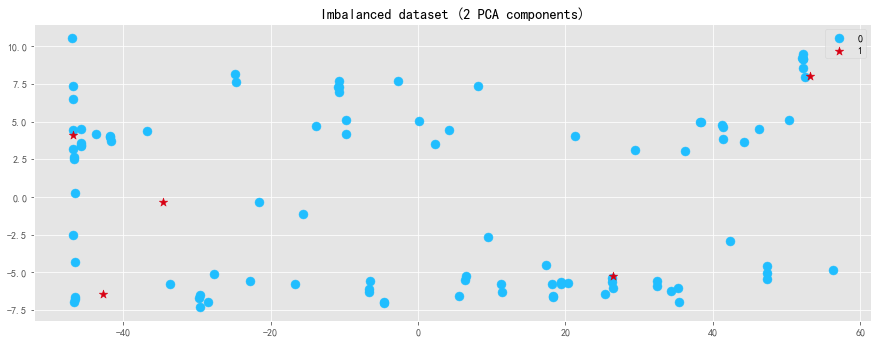

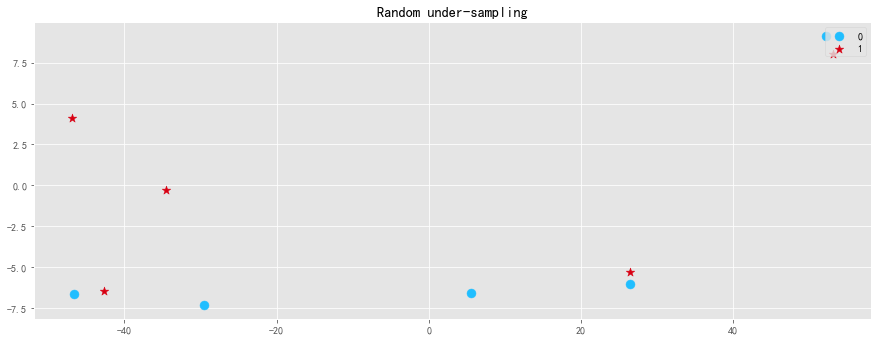

In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=2022)
X_rus, y_rus = rus.fit_resample(X, y)
print(sorted(Counter(y).items()))
print(sorted(Counter(y_rus).items()))

plt.subplot(2,1,1)
plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
plt.subplot(2,1,2)
plot_2d_space(X_rus, y_rus, 'Random under-sampling')

#### Tomek’s links

下面，再向大家介绍一些更高级的方法！

比如欠采样技术中的Tomek links。

> 当我们不必指定每个类里面取出多少数据时，我们可以使用 Tomek's links。


<div align=center>
<img src=https://github.com/datoujinggzj/WhaleDataScienceProject/blob/master/pic/TomekLinks.png?raw=true width='800' />
</div>

那么什么是 Tomek link 呢？

可以理解为正负两类中离得特别近的点所组成的link，移除这些link可以增大类别之间的空间，从而更好地进行分类！

<div align=center>
<img src=https://imbalanced-learn.org/stable/_images/sphx_glr_plot_illustration_tomek_links_001.png width='400' />
</div>

参数 `sampling_strategy` 控制将删除链接的哪个样本。例如，默认值（即 sampling_strategy='auto'）将从多数类中删除样本。可以通过将 sampling_strategy 设置为“全部”来删除多数类和少数类的样本。该图说明了这种行为。

[(0, 95), (1, 5)]
[(0, 93), (1, 5)]


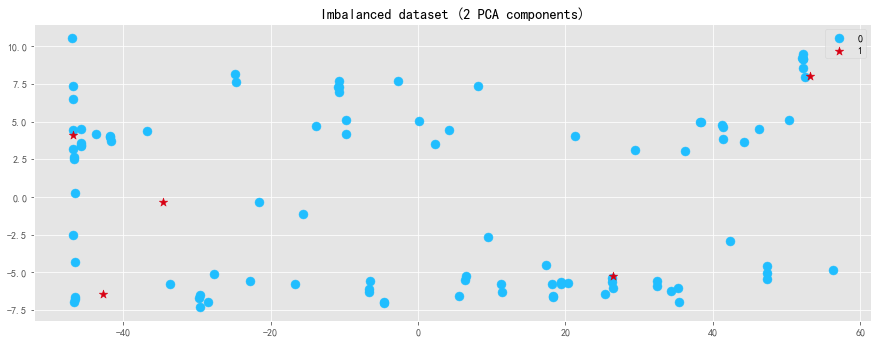

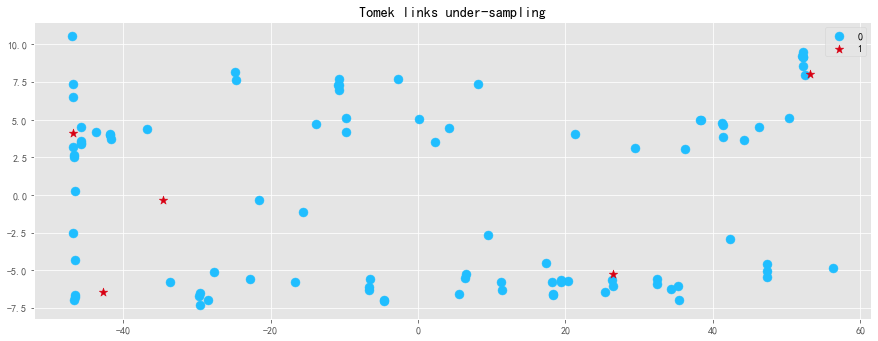

In [16]:
from imblearn.under_sampling import TomekLinks


tl = TomekLinks(sampling_strategy = 'auto')
X_tl, y_tl = tl.fit_resample(X, y)
print(sorted(Counter(y).items()))
print(sorted(Counter(y_tl).items()))

plt.subplot(2,1,1)
plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
plt.subplot(2,1,2)
plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

#### Edited data set using nearest neighbours

`EditedNearestNeighbours`应用最近邻算法并通过删除与其邻域不“足够”一致的样本来“编辑”数据集。

对于要欠采样的类中的每个样本，计算最近邻，如果不满足选择标准，则删除样本：

[(0, 95), (1, 5)]
[(0, 87), (1, 5)]


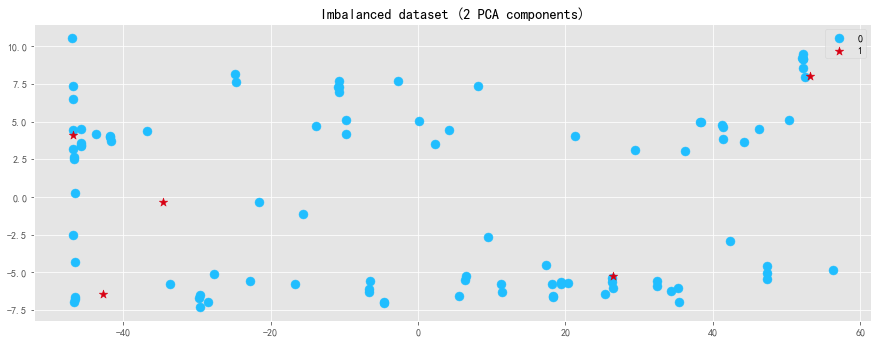

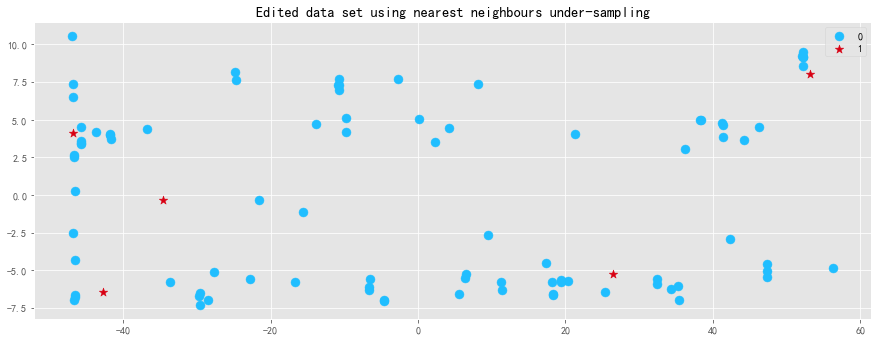

In [17]:
from imblearn.under_sampling import EditedNearestNeighbours


enn = EditedNearestNeighbours(sampling_strategy = 'auto',n_neighbors = 3)
X_enn, y_enn = enn.fit_resample(X, y)
print(sorted(Counter(y).items()))
print(sorted(Counter(y_enn).items()))

plt.subplot(2,1,1)
plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
plt.subplot(2,1,2)
plot_2d_space(X_enn, y_enn, 'Edited data set using nearest neighbours under-sampling')

#### Repeated Edited data set using nearest neighbours

作为 Edited data set using nearest neighbours 的拓展，我们将此算法重复多次，会移除更多的数据！

[(0, 95), (1, 5)]
[(0, 76), (1, 5)]


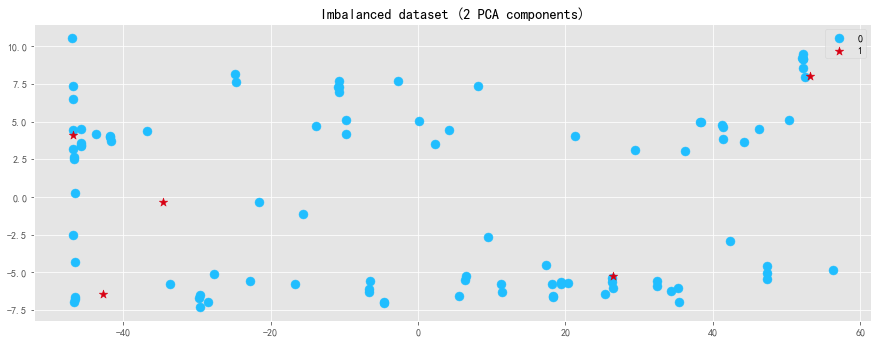

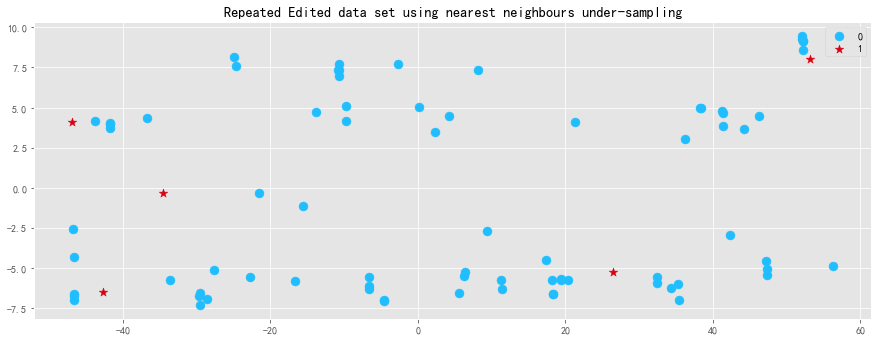

In [18]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours


renn = RepeatedEditedNearestNeighbours(sampling_strategy = 'auto',n_neighbors = 3)
X_renn, y_renn = renn.fit_resample(X, y)
print(sorted(Counter(y).items()))
print(sorted(Counter(y_renn).items()))

plt.subplot(2,1,1)
plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
plt.subplot(2,1,2)
plot_2d_space(X_renn, y_renn, 'Repeated Edited data set using nearest neighbours under-sampling')

#### AllKNN

AllKNN 在之前的 RepeatedEditedNearestNeighbours 基础上，neighbors在每次迭代时都会增加。

[(0, 95), (1, 5)]
[(0, 84), (1, 5)]


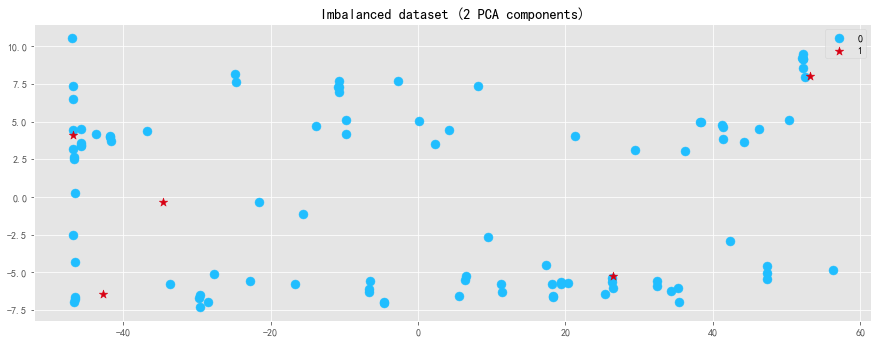

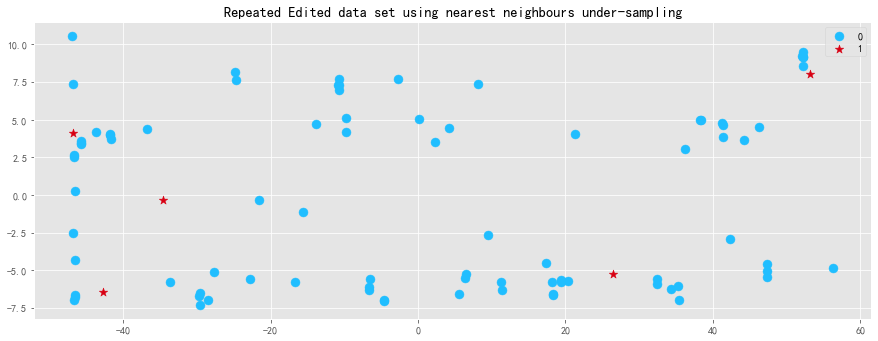

In [19]:
from imblearn.under_sampling import AllKNN

allknn = AllKNN(sampling_strategy = 'auto',n_neighbors = 3)
X_allknn, y_allknn = allknn.fit_resample(X, y)
print(sorted(Counter(y).items()))
print(sorted(Counter(y_allknn).items()))

plt.subplot(2,1,1)
plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
plt.subplot(2,1,2)
plot_2d_space(X_allknn, y_allknn, 'Repeated Edited data set using nearest neighbours under-sampling')

#### Cluster Centroids

通过基于聚类方法生成质心来执行欠采样。数据将先前按相似性分组，以保存信息。

[(0, 95), (1, 5)]
[(0, 5), (1, 5)]


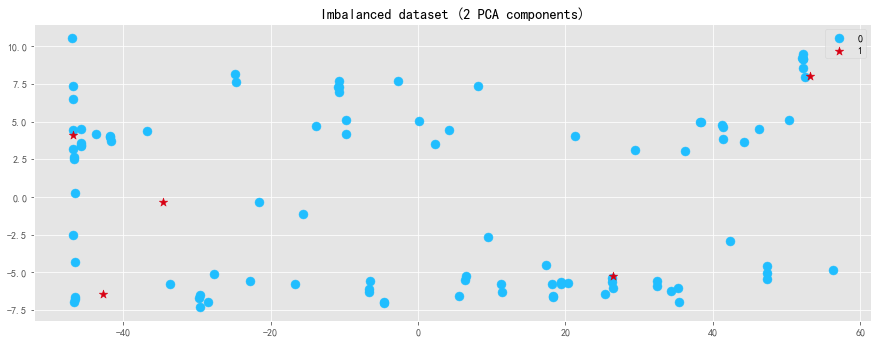

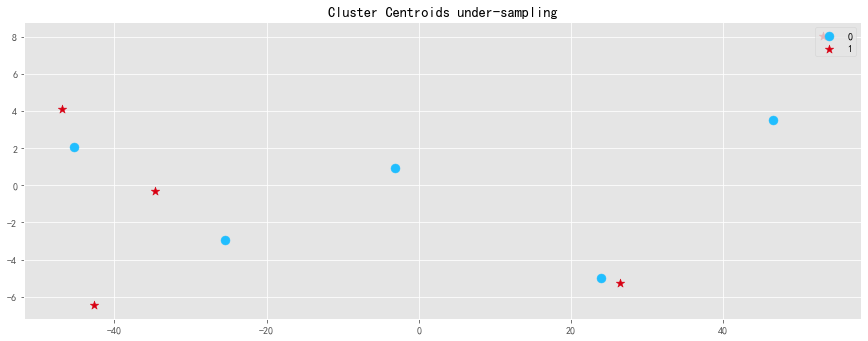

In [20]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X, y)
print(sorted(Counter(y).items()))
print(sorted(Counter(y_cc).items()))

plt.subplot(2,1,1)
plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
plt.subplot(2,1,2)
plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

![](https://github.com/datoujinggzj/WhaleDataScienceProject/blob/master/pic/sep.gif?raw=true)

### Over-sampling

- RandomOverSampler
- SMOTE 
- ADASYN

#### RandomOverSampler

90 new random picked points
[(0, 95), (1, 5)]
[(0, 95), (1, 95)]


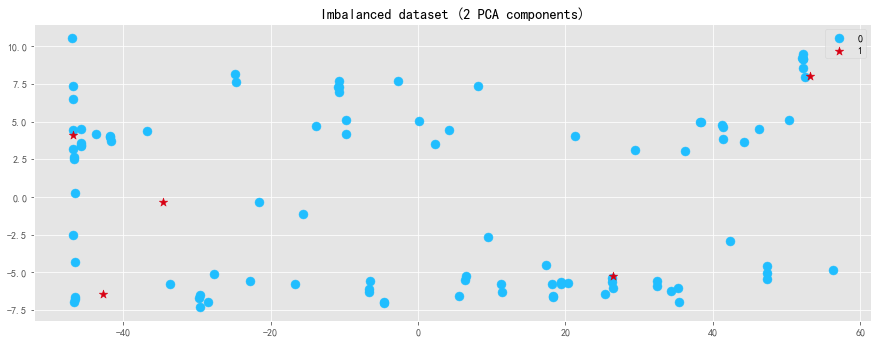

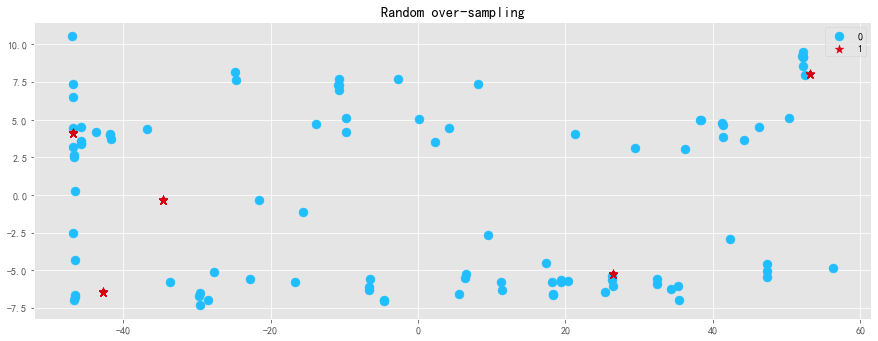

In [21]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')
print(sorted(Counter(y).items()))
print(sorted(Counter(y_ros).items()))

plt.subplot(2,1,1)
plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
plt.subplot(2,1,2)
plot_2d_space(X_ros, y_ros, 'Random over-sampling')

# 星星的部分重复sample，所以二维图大家是看不见的，被覆盖了。

#### SMOTE

SMOTE（Synthetic Minority Oversampling TEchnique）由基于已经存在的少数类的合成元素组成。它从少数类中随机挑选一个点并计算该点的 k 最近邻。合成点被添加到所选点与其相邻点之间。

> SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

---

> The combination of SMOTE and under-sampling performs better than plain under-sampling.

<div align=center>
<img src=https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png width='800' />
</div>

<div align=center>
<img src=https://www.datasciencecentral.com/wp-content/uploads/2021/10/2808332241.png width='600' />
</div>

In [ ]:
from imblearn.over_sampling import SMOTE,BorderlineSMOTE,SVMSMOTE,KMeansSMOTE # 几种变式

smote = SMOTE(k_neighbors=3)
X_sm, y_sm = smote.fit_resample(X, y)

smote_border = BorderlineSMOTE(k_neighbors=3)
X_smbl, y_smbl = smote_border.fit_resample(X, y)

smote_svm = SVMSMOTE(k_neighbors=3)
X_smsvm, y_smsvm = smote_svm.fit_resample(X, y)


plt.subplot(4,1,1)
plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
plt.subplot(4,1,2)
plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling【k neighbors=3】')
plt.subplot(4,1,3)
plot_2d_space(X_smbl, y_smbl, 'BorderlineSMOTE over-sampling【k neighbors=3】')
plt.subplot(4,1,4)
plot_2d_space(X_smsvm, y_smsvm, 'SVMSMOTE over-sampling【k neighbors=3】')

在处理连续特征和分类特征等混合数据类型时，所提出的方法（除了类随机过采样器）都不能处理分类特征。

这时候，我们应该使用`SMOTENC`来去对类别型变量做特殊的处理。

点击[这里](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC)查看详情。

#### ADASYN

自适应合成（ADASYN）是基于使用K近邻根据少数数据样本的分布自适应生成少数数据样本的思想。该算法自适应地更新分布，并且对数据的潜在分布不做任何假设。该算法使用欧几里德距离作为KNN算法。

**ADASYN和SMOTE之间的关键区别在于**，前者使用密度分布作为标准，通过自适应地改变不同少数样本的权重来补偿偏态分布，从而自动决定必须为每个少数样本生成的合成样本数。后者为每个原始少数群体样本生成相同数量的合成样本。


> SMOTE and ADASYN generate new samples in by interpolation. 

---

> ADASYN works similarly to the regular SMOTE. However, the number of samples generated for each x_i is proportional to the number of samples which are not from the same class than x_i in a given neighborhood. Therefore, more samples will be generated in the area that the nearest neighbor rule is not respected. The parameter m_neighbors is equivalent to k_neighbors in SMOTE.

[(0, 95), (1, 5)]
[(0, 95), (1, 95)]


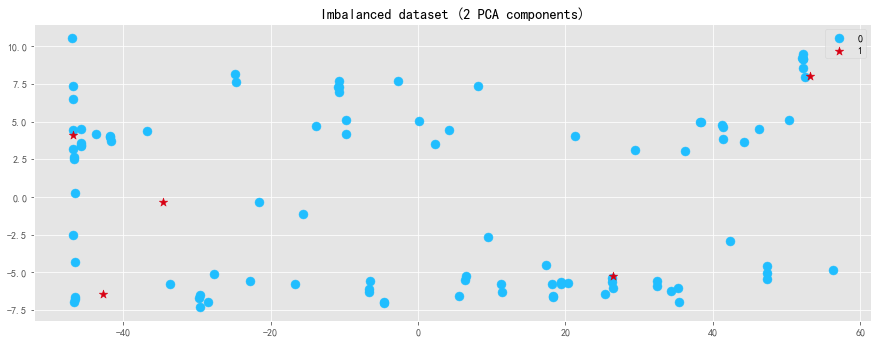

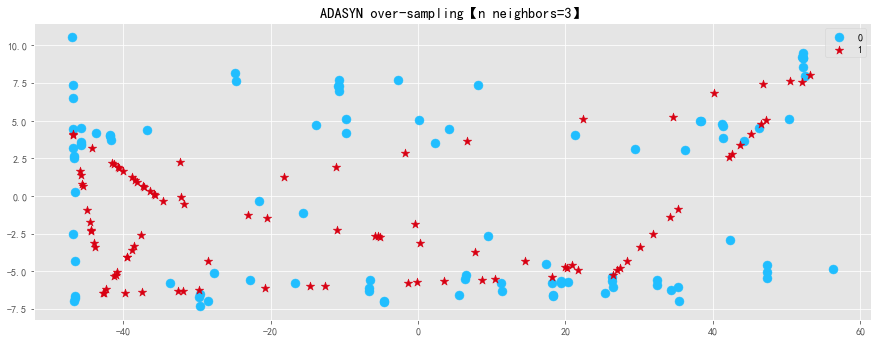

In [23]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(n_neighbors = 3)
X_ada, y_ada = ada.fit_resample(X, y)

print(sorted(Counter(y).items()))
print(sorted(Counter(y_ada).items()))

plt.subplot(2,1,1)
plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
plt.subplot(2,1,2)
plot_2d_space(X_ada, y_ada, 'ADASYN over-sampling【n neighbors=3】')

###  Combination of over- and under-sampling

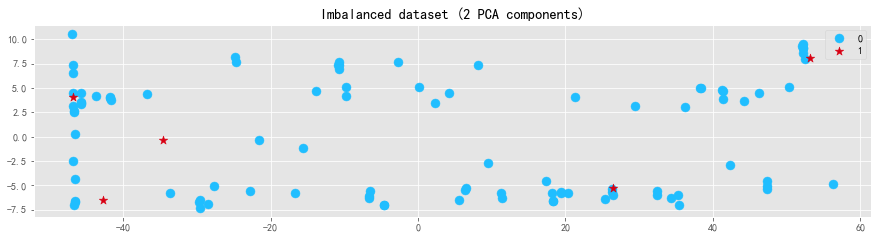

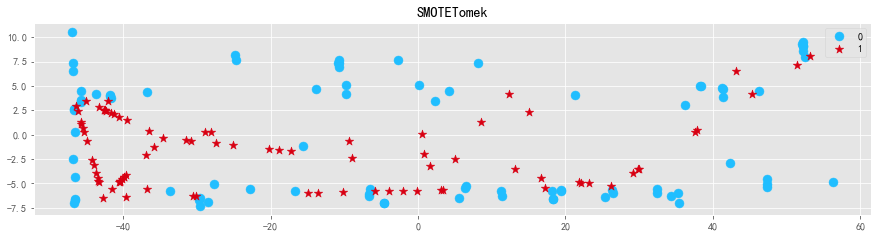

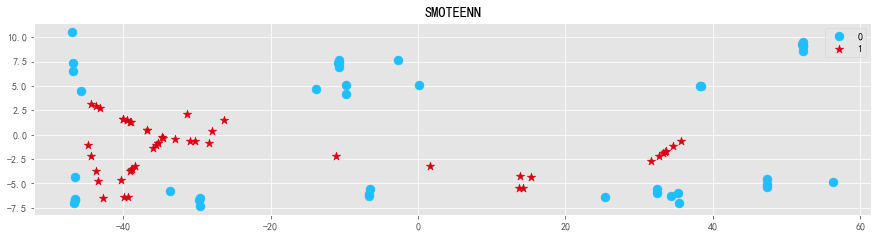

In [24]:
from imblearn.combine import SMOTETomek,SMOTEENN
smote_tomek = SMOTETomek(random_state=0,smote = SMOTE(k_neighbors=3))
X_smtom, y_smtom = smote_tomek.fit_resample(X, y)

smote_enn = SMOTEENN(random_state=0,smote = SMOTE(k_neighbors=3))
X_smen, y_smen = smote_enn.fit_resample(X, y)

plt.subplot(3,1,1)
plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
plt.subplot(3,1,2)
plot_2d_space(X_smtom, y_smtom, 'SMOTETomek')
plt.subplot(3,1,3)
plot_2d_space(X_smen, y_smen, 'SMOTEENN')

可看到，Smotenn比SMOTETomek更容易清除噪音样本。

![](https://github.com/datoujinggzj/WhaleDataScienceProject/blob/master/pic/sep.gif?raw=true)

## 练习

下面我们来做一些练习吧！

1. 首先，我们遇到了什么问题？

😂 数据类别不平衡，97%的数据对应的标签是【不索赔】，我们不想知道不索赔的人有什么特点，我们关注的是索赔的人有什么样的特征，期待模型去从3%的数据中挖掘有效的特征。

2. 如何解决？

👉 重采样，resampling。

- 从majority的类别中（这里就是target=0的数据）移除一些样本，这是欠采样（**上图的左上角**）
- 从minority的类别中（target=1）增加一些样本，这是过采样（**上图右上角**）

👉 Imblearn

- Tomek link / ENN
- SMOTE / ADASYN
- Combination

👉 注意：这些方法不能完美解决imbalance的问题，有利有弊。

导入训练集数据

In [8]:
train = pd.read_csv('/Users/sarahluym/Desktop/求职/Projects/Github/WhaleDataScienceProject/data/train.csv')

$$
undersampling~rate = \frac{(1-r)*{minority~size}}{r*majority~size}\\
where ~r = desired~proportion~rate
$$

<div class="alert alert-block alert-success"><b>Step 1 (5分)</b>: 
    
根据指示完成下面的函数`undersampling`。
</div>

In [17]:
def undersampling(df, desired_prop_rate = 0.15):
    # 获取target=0和1的index
    idx_class_0 = df[df['target'] == 0].index
    idx_class_1 = df[df['target'] == 1].index
    
    # 获取target=0和1的个数
    count_class_0 = df['target'].value_counts()[0]
    count_class_1 = df['target'].value_counts()[1]
    
    # 根据上面的公式计算undersampling rate
    undersampling_rate = (1 - desired_prop_rate) * min(count_class_0, count_class_1) / (desired_prop_rate * max(count_class_0, count_class_1))
    undersampled_majority_size = round(max(count_class_0, count_class_1) * undersampling_rate)
    
    print(f"关于target=0的欠采样比率为:【{undersampling_rate}】")
    print(f"在欠采样之后，target=0的数量为：【{undersampled_majority_size}】")
    
    
    from sklearn.utils import shuffle
    # 用shuffle函数对target=0的所有数据打乱抽样，seed=100,抽样数为刚刚计算的值
    undersampled_idx = shuffle(idx_class_0, random_state=100, n_samples=undersampled_majority_size)
    
    # 把undersampling之后的idx和之前的target=1的idx合并，并在train里面根据idx把数据索引出来
    idx_total = undersampled_idx.append(idx_class_1)
    
    df = df.loc[idx_total].reset_index(drop=True)
    
    return df

In [18]:
undersampling(df = train)

关于target=0的欠采样比率为:【0.21434840173571998】
在欠采样之后，target=0的数量为：【122933】


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,744529,0,2,1,9,1,0,0,0,1,...,5,1,2,8,0,0,1,0,0,0
1,673907,0,1,1,2,1,0,0,1,0,...,6,4,4,9,1,1,1,1,1,0
2,730796,0,7,1,6,0,4,0,0,0,...,3,1,3,7,0,1,1,0,0,0
3,306142,0,1,1,3,0,0,1,0,0,...,5,0,2,9,0,0,1,0,0,0
4,1102701,0,6,2,7,1,0,0,1,0,...,6,0,2,9,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144622,1487473,1,5,1,7,0,3,0,0,1,...,10,1,5,7,0,1,1,0,0,0
144623,1487566,1,1,1,5,0,0,0,0,1,...,9,2,1,5,0,1,0,0,0,0
144624,1487716,1,0,1,6,1,0,0,1,0,...,3,2,1,6,0,1,1,0,0,0
144625,1487748,1,0,2,2,0,0,1,0,0,...,5,0,4,4,0,0,1,0,1,0


In [27]:
undersampling(df = train)

关于target=0的欠采样比率为:【0.21434840173571998】
在欠采样之后，target=0的数量为：【122932】


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,744529,0,2,1,9,1,0,0,0,1,...,5,1,2,8,0,0,1,0,0,0
1,673907,0,1,1,2,1,0,0,1,0,...,6,4,4,9,1,1,1,1,1,0
2,730796,0,7,1,6,0,4,0,0,0,...,3,1,3,7,0,1,1,0,0,0
3,306142,0,1,1,3,0,0,1,0,0,...,5,0,2,9,0,0,1,0,0,0
4,1102701,0,6,2,7,1,0,0,1,0,...,6,0,2,9,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144621,1487473,1,5,1,7,0,3,0,0,1,...,10,1,5,7,0,1,1,0,0,0
144622,1487566,1,1,1,5,0,0,0,0,1,...,9,2,1,5,0,1,0,0,0,0
144623,1487716,1,0,1,6,1,0,0,1,0,...,3,2,1,6,0,1,1,0,0,0
144624,1487748,1,0,2,2,0,0,1,0,0,...,5,0,4,4,0,0,1,0,1,0


现在，把刚刚得到的数据存储起来，用df.to_csv()。

In [20]:
undersampling(df=train).to_csv('/Users/sarahluym/Desktop/求职/Projects/Github/WhaleDataScienceProject/porto-seguro-safe-driver-prediction/Phase3/Exe&Sol/undersampling.csv')

关于target=0的欠采样比率为:【0.21434840173571998】
在欠采样之后，target=0的数量为：【122933】


<div class="alert alert-block alert-success"><b>Step 2</b>: 
    
尝试用`SMOTEENN`对数据进行处理。
</div>

In [25]:
n_comp = 20
print('\nPCA执行中...')
pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)

X_ = train[features]
y_ = train['target']
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=1996)


X_pca = pca.fit_transform(X_train)
print('Total Explained variance: %.4f' % pca.explained_variance_ratio_.sum())


PCA执行中...
Total Explained variance: 0.9944


Text(9, 0.97, 'cumulative explained var: 0.98')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


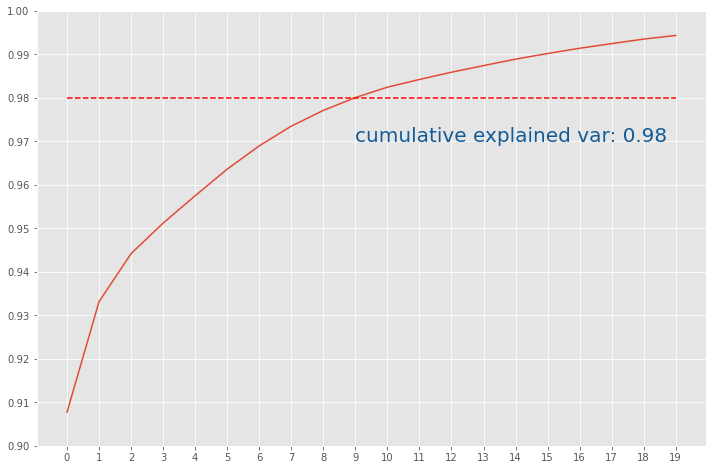

In [26]:
plt.figure(figsize = [12,8])

pd.Series(pca.explained_variance_ratio_).cumsum().plot()

plt.plot(range(n_comp),[0.98]*20, 'r--')
plt.xticks(ticks = range(n_comp))
plt.yticks(ticks = np.linspace(0.9,1,11))
plt.text(9,0.97,'cumulative explained var: 0.98',fontsize = 20, color = '#125b97')

所以，我们需要取出能够解释98%的variance的最少的n个principle component，那么n是多少呢？

In [27]:
n = 9

In [28]:
pca = PCA(n_components= n, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(X_train)

In [ ]:
from imblearn.combine import SMOTEENN, SMOTE  # random_state = 0
smote_enn = SMOTEENN(random_state=0, smote=(SMOTE(k_neighbors=9)))
X_smen, y_smen = smote_enn.fit_resample(X, y)